In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from copy import deepcopy
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# plt.style.use('dark_background')
import mat4py
import data
import pickle as pkl
from viz import *
import viz
import trend_filtering

In [2]:
df = data.get_data(use_processed=True) # all_data=True
df = df[df['valid'] == 1] # exclude test cells, short/long tracks, hotspots
outcome = 'y_consec_thresh'

# look at tracks themselves

In [18]:
auxilin_dir = '/scratch/users/vision/data/abc_data/auxilin_data_tracked'

# 8 cell folders [1, 2, 3, ..., 8]
cell_num = 1
fname = f'{auxilin_dir}/A7D2/Cell{cell_num}_1s/TagRFP/Tracking/ProcessedTracks.mat'
# cla, aux = get_images(f'Cell{cell_num}_1s', auxilin_dir=auxilin_dir)
# fname_image = data_dir = oj(auxilin_dir, 'A7D2', f'Cell{cell_num}_1s')
mat = mat4py.loadmat(fname)
tracks = mat['tracks']

In [19]:
tracks.keys()

dict_keys(['t', 'f', 'x', 'y', 'A', 'c', 'x_pstd', 'y_pstd', 'A_pstd', 'c_pstd', 'sigma_r', 'SE_sigma_r', 'pval_Ar', 'isPSF', 'tracksFeatIndxCG', 'gapVect', 'gapStatus', 'gapIdx', 'seqOfEvents', 'nSeg', 'visibility', 'lifetime_s', 'start', 'end', 'startBuffer', 'endBuffer', 'MotionAnalysis', 'maskA', 'maskN', 'RSS', 'mask_Ar', 'hval_Ar', 'hval_AD', 'catIdx', 'isCCP', 'significantMaster', 'significantVsBackground', 'significantSlave'])

# visualize a single example

In [ ]:
# pick a single interesting example
# ex = df[df.lifetime > 250].iloc[0]
ex = df[(df.lifetime > 30) * (df[outcome] == 1)]
ex = ex.sort_values(by='Y_max')
# .iloc[5]
ex = ex.iloc[-5]
viz.plot_example(ex)

# basic eda

In [ ]:
viz.plot_curves(df, hline=False)

In [ ]:
plt.plot(df['x_pos'], df['y_pos'], 'o', alpha=0.1)

# look at displacement features

In [3]:
# functions to compute msd of track over time
def rmsd(a, b):
    '''msd
    '''
    da = np.diff(a)
    db = np.diff(b)
    return np.sum(np.sqrt(np.square(da) + np.square(db)))

def rmsd_end(a, b):
    '''msd at end
    '''
    l = int(len(a) * 0.25 + 5)
    da = np.diff(a)[-l:]
    db = np.diff(b)[-l:]
    return np.sum(np.sqrt(np.square(da) + np.square(db)))

def rmsd_curve(a, b):
    '''curve of sd
    '''
    da = np.diff(a)
    db = np.diff(b)
    return np.sqrt(np.square(da) + np.square(db))

x = df['x_pos_seq'].values
y = df['y_pos_seq'].values
msd_tot = [rmsd_curve(a, b) for a, b in zip(x, y)]
df['msd_alt'] = msd_tot

In [ ]:
R, C = 2, 1
d = df[df[outcome]==1]
plt.figure(figsize=(8, 4), dpi=300)
plt.subplot(R, C, 1)
means_last_20 = 0
N = 50
for i in range(N):
    r = d.iloc[i]
    y_max_idx = r['Y_peak_idx']
#     y_max_idx = r.lifetime
#     xs = np.arange(r.lifetime - 1) / (r.lifetime - 1)
    xs = np.arange(y_max_idx) / (y_max_idx - 1)
    ys = np.cumsum(r['msd_alt'])
    ys = r['msd_alt']
    plt.plot(xs, ys[:y_max_idx], alpha=0.2, color=cb)
    means_last_20 += np.mean(ys[int(y_max_idx * 0.8):])
plt.xticks([])
plt.ylim(0, 4)
plt.ylabel('aux+\ndisplacement')

means_last_20_neg = 0
plt.subplot(R, C, 2)    
d = df[(df[outcome]==0) & (df.lifetime > 30)]
for i in range(N):
    r = d.iloc[i]
    y_max_idx = r['Y_peak_idx']
#     y_max_idx = r.lifetime
    xs = np.arange(y_max_idx) / (y_max_idx - 1)
    ys = np.cumsum(r['msd_alt'])
    ys = r['msd_alt']
    plt.plot(xs, ys[:y_max_idx], alpha=0.2, color=cr)    
    means_last_20_neg += np.mean(ys[int(y_max_idx * 0.8):])
print('means', means_last_20, means_last_20_neg)
plt.ylim(0, 4)    
plt.xlabel('time to aux peak (frac)')
plt.ylabel('aux- \ndisplacement')    
plt.show()

In [ ]:
viz.jointplot_grouped('msd_alt', 'fall', 'y_consec_thresh', df, scatter_alpha=0.1)
plt.savefig('msd_alt_fall.png', dpi=400)

In [ ]:
# plt.plot(df['msd_tot'], df['Y_max'], 'o', alpha=0.1)
# sns.lmplot('msd_tot', 'Y_max', data=df)
sns.jointplot('msd_alt', 'Y_max', data=df, kind='reg')
plt.ylabel('aux max')
plt.savefig('msd_alt.png', dpi=400)
# sns.jointplot(x, y, kind="reg", stat_func=r2)

# look at learned dictionaries

In [ ]:
print(os.listdir('processed/dictionaries'))
# d = pkl.load(open(f'processed/dictionaries/' + 'sc_12_alpha=1.pkl', 'rb'))
d = pkl.load(open(f'processed/dictionaries/' + 'nmf_12.pkl', 'rb'))
R, C = 3, 4
i = 0
plt.figure(dpi=200)
vmin = d.components_.min()
vmax = d.components_.max()
# print('err', d.reconstruction_err_ / np.linalg.norm(X_mat, ord='fro'))
for r in range(R):
    for c in range(C):
        plt.subplot(R, C, i + 1)
        plt.plot(d.components_[i], color=cr)
        i += 1
        plt.ylim((vmin, vmax))
        if r < R-1:
            plt.xticks([])
        if c > 0:
            plt.yticks([])
plt.tight_layout()
plt.show()

# viz tracks where auxilin peaks first

In [ ]:
outcomes = ['y_thresh', 'y_consec_sig', 'y_consec_thresh']
for outcome in outcomes:
    X_peak_idx = np.array([np.argmax(x) for x in df.X])
    Y_peak_idx = np.array([np.argmax(y) for y in df.Y])
    idxs_err = Y_peak_idx < X_peak_idx
    df_err = df[idxs_err]
    df_err_pos = df_err[df_err[outcome] == 1]
    num_pos = df[df[outcome] == 1].shape[0]
    num_pos_err = df_err_pos.shape[0] 
    frac_pos_err = num_pos_err / num_pos
    print('num tot', df.shape[0], 'num aux peaks first', df_err.shape[0], f'frac pos aux peaks first {frac_pos_err:0.3f}')
    viz.plot_curves(df_err_pos)

In [ ]:
plt.figure(dpi=300)
plt.hist(df_err_pos.lifetime, bins=20, color=cb)
plt.xlabel('lifetime')
plt.ylabel('count')
plt.title('aux+ with auxilin peaking first')
plt.show()

In [ ]:
R, C = 2, 1
plt.figure(dpi=200)
plt.subplot(R, C, 1)
plt.hist(X_peak_idx[idxs_err], color=cr)
plt.xlabel('Clathrin peak time')
plt.ylabel('Count')
plt.subplot(R, C, 2)
plt.hist(Y_peak_idx[idxs_err], color=cr)
plt.xlabel('Auxilin peak time')
plt.ylabel('Count')
plt.tight_layout()

# visualize splines

In [ ]:
viz.plot_curves(df_err, extra_key='X_smooth_spl')

# analyze tracking

In [1]:
fname = f'/scratch/users/vision/data/abc_data/auxilin_data_tracked/A7D2/Cell1_1s/TagRFP/Tracking/ProcessedTracks.mat'
mat = mat4py.loadmat(fname)
tracks = mat['tracks']

In [3]:
i = 2
x = tracks['x'][i][0]
xx = tracks['x'][i][1]

print('clath', len(x), 'aux', len(xx))

clath 300 aux 300


In [ ]:
for i in range(1000):
    print(tracks['t'][i][:5])

# feats centered around peak
**gets the clathrin traces aligned by their maximum, padded by zeros when necessary**

In [75]:
def get_peak(row, num=21):
    vals = np.empty(2 * num + 1) * np.nan 
    # vals = np.zeros(2 * num + 1)
    x = row['X']
    peak_idx = row['X_peak_idx']
    x_before = x[max(0,  peak_idx - num): peak_idx]
    
    vals[num - len(x_before): num] = x_before
    vals[num] = x[peak_idx]
    
    x_after = x[peak_idx + 1: peak_idx + num + 1]
    vals[num + 1: num + 1 + len(x_after)] = x_after
    return vals
mat = np.vstack(df.apply(get_peak, axis=1).values)
window_size = mat[0].size
mid = (window_size // 2)

In [ ]:
outcome_def = 'y_consec_thresh'
R, C = 8, 8
i = 0
plt.figure(figsize=(C, R), dpi=200)
vmin = np.nanmin(mat)
vmax = np.nanmax(mat)
# print('err', d.reconstruction_err_ / np.linalg.norm(X_mat, ord='fro'))

pos = df[outcome_def]==1
args = np.argsort(df[pos]['fall_local_11'].values)
mat_pos = mat[pos][args]
falls = df['fall_local_11'][pos].iloc[args].values

for r in range(R):
    for c in range(C):
        plt.subplot(R, C, i + 1)
        plt.title(f'{falls[i]:.2e}')
        plt.plot(mat_pos[i * 8], color=cb, lw=1)
        plt.plot(mid, mat_pos[i * 8][mid], 'o', color='white', ms=2)
        
        
        plt.ylim((vmin, vmax))
        if r < R-1:
            plt.xticks([])
        if c > 0:
            plt.yticks([])
            
        i += 1
plt.tight_layout()
# plt.savefig('peak_aligned.pdf')
plt.show()

# pairplot of most relevant feats

In [ ]:
d = df[['fall', 'X_max', 'rise', 'slope_end', outcome]]
sns.pairplot(d, hue=outcome)
plt.savefig('out.pdf')
plt.show()

In [ ]:
d = df[['fall', 'fall_extended', 'fall_late_extended'] + [outcome]]
sns.pairplot(d, hue=outcome)
plt.show()

# spike-times plot

In [ ]:
plt.figure(dpi=300)
plt.hist(df['Y_peak_idx'] - df['X_peak_idx'], bins=20)
plt.xlabel('aux peak time - clath peak time')
plt.ylabel('count')
plt.show()

# spike magnitude plot

In [ ]:
plt.figure(dpi=300)
plt.scatter(df['X_max'], df['fall'], c=df['Y_max'], alpha=0.5, marker='.')
plt.colorbar()
plt.xlabel('clath max')
plt.ylabel('fall')
plt.show()

## TP/FP videos

In [13]:
from array2gif import write_gif

In [5]:
X, Y = {}, {}
for cell_num in range(1, 7):
    X[cell_num], Y[cell_num] = data.get_images(f'Cell{cell_num}_1s')

In [7]:
fp_ids = [2466, 2547, 2577, 2612, 2631, 2667, 2679, 2705, 2732, 2750, 2756, 2776, 2795, 2473, 2435, 2962]
tp_ids = [8988, 3174, 2969, 2966, 2944, 2939, 2937, 2920, 2918, 2910, 2889, 2884, 2874, 2861, 2854, 2851]

In [74]:
for idx in fp_ids:
    i = np.where(df['pid'] == idx)[0][0]
    track = df.iloc[i]
    cell_num = track['cell_num']
    minx, miny, maxx, maxy = min(track['x_pos_seq']), min(track['y_pos_seq']), max(track['x_pos_seq']), max(track['y_pos_seq'])
    clath = X[cell_num][int(track['t']):(int(track['t'])+track['lifetime']), :, :][:, (int(miny)-5):(int(maxy)+5), :][:, :, (int(minx)-5):(int(maxx)+5)]
    clath = 255.0 * (clath - X[cell_num].min()) / (clath.max() - X[cell_num].min())
    clip = np.repeat(np.expand_dims(clath, axis=3), 3, axis=3) # convert to rgb
    write_gif(clip, f'fp_clips/{idx}.gif', fps=5)
    
for idx in tp_ids:
    i = np.where(df['pid'] == idx)[0][0]
    track = df.iloc[i]
    cell_num = track['cell_num']
    minx, miny, maxx, maxy = min(track['x_pos_seq']), min(track['y_pos_seq']), max(track['x_pos_seq']), max(track['y_pos_seq'])
    clath = X[cell_num][int(track['t']):(int(track['t'])+track['lifetime']), :, :][:, (int(miny)-5):(int(maxy)+5), :][:, :, (int(minx)-5):(int(maxx)+5)]
    clath = 255.0 * (clath - X[cell_num].min()) / (clath.max() - X[cell_num].min())
    clip = np.repeat(np.expand_dims(clath, axis=3), 3, axis=3) # convert to rgb
    #clip = 255 * (clip - X[cell_num].min()) / (clip.max() - X[cell_num].min())
    write_gif(clip, f'tp_clips/{idx}.gif', fps=5)

In [61]:
clath = X[cell_num][int(track['t']):(int(track['t'])+track['lifetime']), :, :][:, (int(miny)-5):(int(maxy)+5), :][:, :, (int(minx)-5):(int(maxx)+5)]

# kymographs

In [43]:
def plot_kymograph(df, pids, X, Y):
    
    df = df[df.pid.isin(pids)]
    #df = df[df.lifetime >= 50]
    #df = df[df.y_consec_thresh == 0]
    #cla = np.array([[X[df.cell_num.iloc[i]].mean()]*int(df.t.iloc[i])+ 
    #                 [np.mean(X[df.cell_num.iloc[i]][int(df.t.iloc[i]) + j][int(df.y_pos_seq.iloc[i][j]-1):int(df.y_pos_seq.iloc[i][j]+2),:][:,int(df.x_pos_seq.iloc[i][j])])
    #                 for j in range(df.lifetime.iloc[i])] +
    #                 [X[df.cell_num.iloc[i]].mean()]*(300 - int(df.t.iloc[i]) - df.lifetime.iloc[i]) for i in range(len(df))])
    cla = []
    for i in range(len(df)):
        xmean = X[df.cell_num.iloc[i]].mean()
        xmean = X[1].min()
        t, lt = int(df.t.iloc[i]), df.lifetime.iloc[i]
        x_pos, y_pos = df.x_pos_seq.iloc[i], df.y_pos_seq.iloc[i]
        trace = [xmean]*t + [np.mean(X[df.cell_num.iloc[i]][t+j][int(y_pos[j]-1):int(y_pos[j]+2),:][:,int(x_pos[j]-1):int(x_pos[j]+2)]) for j in range(lt)] + [xmean]*(300 - t - lt)
        cla.append(trace)
    cla = np.array(cla)
    #print(cla.max())
    cla = (cla - X[1].min())/(5572 - X[1].min())
    cla_sparse = []
    for i in range(len(df)):
        cla_sparse.append(cla[i])
        cla_sparse.append([0]*300)
        cla_sparse.append([0]*300)
        cla_sparse.append([0]*300)
    aux = np.array([[Y[1].min()]*int(df.t.iloc[i])+ 
                     [Y[df.cell_num.iloc[i]][int(df.t.iloc[i]) + j, int(df.y_pos_seq.iloc[i][j]), int(df.x_pos_seq.iloc[i][j])]
                     for j in range(df.lifetime.iloc[i])] +
                     [Y[1].min()]*(300 - int(df.t.iloc[i]) - df.lifetime.iloc[i]) for i in range(len(df))])
    #print(aux.max())
    aux = (aux - Y[1].min())/(4045 - Y[1].min())
    aux_sparse = []
    for i in range(len(df)):
        aux_sparse.append([0]*300)
        aux_sparse.append(aux[i])
        aux_sparse.append([0]*300)
        aux_sparse.append([0]*300)
    return np.array([[[cla_sparse[i][j], aux_sparse[i][j], 0] for i in range(len(df)*4)] for j in range(300)])

In [75]:
def plot_kymograph_aligned(df, pids, X, Y):
    
    df = df[df.pid.isin(pids)]
    lmax = max(df.lifetime.values)
    #df = df[df.lifetime >= 50]
    #df = df[df.y_consec_thresh == 0]
    #cla = np.array([[X[df.cell_num.iloc[i]].mean()]*int(df.t.iloc[i])+ 
    #                 [np.mean(X[df.cell_num.iloc[i]][int(df.t.iloc[i]) + j][int(df.y_pos_seq.iloc[i][j]-1):int(df.y_pos_seq.iloc[i][j]+2),:][:,int(df.x_pos_seq.iloc[i][j])])
    #                 for j in range(df.lifetime.iloc[i])] +
    #                 [X[df.cell_num.iloc[i]].mean()]*(300 - int(df.t.iloc[i]) - df.lifetime.iloc[i]) for i in range(len(df))])
    cla = []
    for i in range(len(df)):
        xmean = X[df.cell_num.iloc[i]].mean()
        xmean = X[1].min()
        t, lt = int(df.t.iloc[i]), df.lifetime.iloc[i]
        x_pos, y_pos = df.x_pos_seq.iloc[i], df.y_pos_seq.iloc[i]
        trace = [np.mean(X[df.cell_num.iloc[i]][t+j][int(y_pos[j]-1):int(y_pos[j]+2),:][:,int(x_pos[j]-1):int(x_pos[j]+2)]) for j in range(lt)] + [xmean]*(lmax - lt)
        cla.append(trace)
    cla = np.array(cla)
    print(cla.max())
    cla = (cla - X[1].min())/(7681 - X[1].min())
    cla_sparse = []
    for i in range(len(df)):
        cla_sparse.append(cla[i])
        cla_sparse.append([0]*lmax)
        cla_sparse.append([0]*lmax)
        cla_sparse.append([0]*lmax)
    aux = np.array([[Y[df.cell_num.iloc[i]][int(df.t.iloc[i]) + j, int(df.y_pos_seq.iloc[i][j]), int(df.x_pos_seq.iloc[i][j])]
                     for j in range(df.lifetime.iloc[i])] +
                     [Y[1].min()]*(lmax - df.lifetime.iloc[i]) for i in range(len(df))])
    print(aux.max())
    aux = (aux - Y[1].min())/(6346 - Y[1].min())
    aux_sparse = []
    for i in range(len(df)):
        aux_sparse.append([0]*lmax)
        aux_sparse.append(aux[i])
        aux_sparse.append([0]*lmax)
        aux_sparse.append([0]*lmax)
    return np.array([[[cla_sparse[i][j], aux_sparse[i][j], 0] for i in range(len(df)*4)] for j in range(lmax)])

In [ ]:
kg = plot_kymograph_aligned(df, fp_ids, X, Y)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(kg, aspect=.2)
ax.set_xticks([])

In [ ]:
kg = plot_kymograph(df, tp_ids, X, Y)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(kg, aspect=.2)
ax.set_xticks([])

In [72]:
#np.argsort(df.Y_max)[::-1][:50]
tp_ids = df.pid.values[np.argsort(df.Y_max)[::-1][:50]]
kg = plot_kymograph_aligned(df, tp_ids, X, Y)

7680.333333333333
6346


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(kg, aspect=0.5)
ax.set_xticks([])

In [ ]:
tn_ids = df.pid.values[np.argsort(df.Y_max)[:50]]
kg = plot_kymograph_aligned(df, tn_ids, X, Y)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(kg, aspect=0.5)
ax.set_xticks([])

### Random projections

In [118]:
from sklearn.random_projection import GaussianRandomProjection as GRP

df = data.get_data(use_processed=True) 
feat_names = data.get_feature_names(df)

# don't use dict_feats
feat_names = [x for x in feat_names 
              if not x.startswith('sc_') 
              and not x.startswith('nmf_')
              and not x in ['center_max', 'left_max', 'right_max', 'up_max', 'down_max', 
                            'X_max_around_Y_peak', 'X_max_after_Y_peak', 'X_max_diff_after_Y_peak',
                           'X_peak_last_15', 'X_peak_last_5', 'X_peak_time_frac', 
                           'rise_extended', 'fall_extended', 'fall_late_extended', 'lifetime_extended']
              and not x.startswith('pc_')
#               and not 'local' in x
#               and not 'X_peak' in x
#               and not 'slope' in x
#               and not x in ['fall_final', 'fall_slope', 'fall_imp', 'fall']
             ]

In [ ]:
feat_names

In [131]:
feat_names = feat_names[:12]
for name in feat_names:
    #if 'peak' not in name:
    df[name] = boxcox(df[name] - df[name].min() + 1)[0]

X = df[feat_names]
X = (X - X.mean()) / X.std()

In [132]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_new_pca = pca.fit_transform(X)

In [153]:
grp = GRP(n_components=2)
X_new = grp.fit_transform(X)

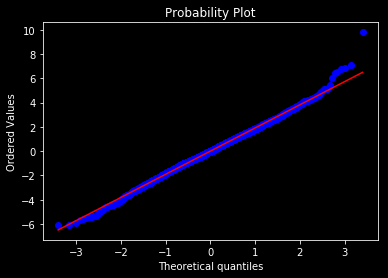

In [156]:

import pylab 
import scipy.stats as stats

#X_trans = boxcox(df['X_max'])
stats.probplot(X_new[:, 0], dist="norm", plot=pylab)
#stats.probplot(X_new[:, 1], dist="norm", plot=pylab)
pylab.show()


In [12]:
df_tf = deepcopy(df)
for i in range(len(df)):
    df_tf['X'].iloc[i] = trend_filtering.trend_filtering(y=df['X'].iloc[i], vlambda=len(df['X'].iloc[i])*2, order=3) 
#df_tf = preprocess(df_tf)

Text(0.5, 1.0, 'order 3 trend filtering')

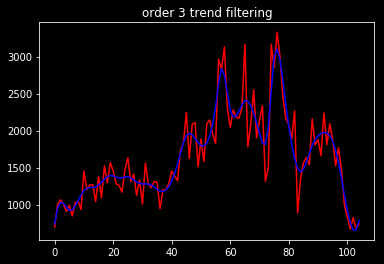

In [13]:
plt.plot(df['X'].iloc[2], color='red')
plt.plot(df_tf['X'].iloc[2], color='blue')
plt.title("order 3 trend filtering")

# label checking

In [20]:
neg = [221, 248, 255, 274, 291, 294, 350, 358, 364, 384, 434, 481, 518, 535, 588, 590, 602, 604, 638, 668, 675, 708, 752, 778, 808, 827]
pos = [3982, 8243, 777, 3940, 7559, 2455, 4748, 633, 2177, 1205, 603, 7972, 8458, 3041, 924, 8786, 4116, 885, 6298, 4658, 7889, 982, 829, 1210, 3054, 504]

n1 = len(neg)

full = np.array(neg + pos)
n2 = len(full)
print(n1, n2)

26 52


In [23]:
import random
random.seed(15)
samps = np.array(random.sample(range(n2), 36))
pids = full[samps]
labs = samps >= n1

In [ ]:
viz.plot_curves(df[df.pid.isin(pids)]) #, extra_key='X_smooth_spl')